MNIST esetén egy sima konvolúciós háló

![alt text](https://miro.medium.com/max/3744/1*SGPGG7oeSvVlV5sOSQ2iZw.png)

Általános esetben

![alt text](https://miro.medium.com/max/772/1*kkyW7BR5FZJq4_oBTx3OPQ.png)

A kódban már csak azokhoz a lépésekhez fűztem kommentet, amelyek nem voltak vagy változtak a fullyconnectedhez képest.

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting tmp/MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting tmp/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mni

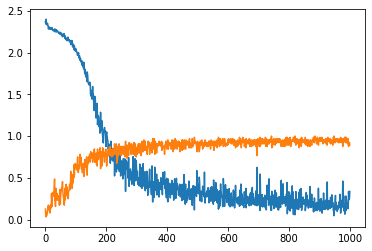

In [1]:
#imports

import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data as data 
mnist_data = data.read_data_sets('tmp/MNIST_data/', one_hot=True)


#finding the data and the label shapes

#a konvolúciós nnben egy (pontosabban egy batchnyi) kivágott képet veszünk ki a nagyból
#ennek a mérete a kernelünktől fog függeni
#az input tömbünk megegyezik a kép méretével(784 = 28*28) és színével(feketefehér -> 1dim -> 1): [28, 28, 1] 

#itt ki lehet iratni pár fancységet, de nem lényeg
#print('Input size: ' + str(mnist_data.train.images.shape[1]))
#img = mnist_data.train.images[0]
#img = np.reshape(img, [28,28])
#plt.imshow(img)

#hyperparameters

#most nem a méretét adjuk meg hanem az alakját 
input_shape = [28, 28, 1]
num_classes = mnist_data.train.labels.shape[1]
batch_size = 64
#itt most nem layereket adunk meg hanem a kerneleink számát az adott layerekhez
num_kernels = [32, 64, 128]
num_iterations = 1000


#graph building

tf.reset_default_graph()

#az input datánál most mivel nem egy méretünk hanem egy alakunk van ezért konkatenálnunk kell a batch méretével
input_data = tf.placeholder(tf.float32, [batch_size] + input_shape)
expected_output = tf.placeholder(tf.float32, [batch_size, num_classes])

current_input = input_data
#az inputunkon mivel 1 darab kép ezért csak egy kernelünk lehet
#ha rgb-s a képünk akkor ez a dimenziók miatt 3, de adattól függ így itt nem tesztelhető
input_channels = input_shape[-1]

#végig iterálunk az összes layeren, ami meg fog egyezni a kernelek számával
for ind, val in enumerate(num_kernels):

  #azért használtam enumaratet, hogy itt be tudjam rakni az indexet
  with tf.variable_scope('layer' + str(ind)):

    #itt meghatározunk egy 3x3as kernelt, ami az előző layer méretéből a mostaniba visz át
    #kicsit úgy kell elképzelni mint egy szűrőt -> layerenként jóval kevesebb neuront igényel
    w = tf.get_variable('kernel', [3, 3, input_channels, val])

    b = tf.get_variable('b', [val])

    #kovolúció maga az első két paraméter elv triviális
    #a strides az azért 1,1,1,1 mert így ugyanakkora lesz az input és az output mérete
    #hasonlóan a pedding, ha SAME akkor csak a stride lesz hatással a kép méretének változására a kernel nem
    current_input = tf.nn.conv2d(input=current_input, filter=w, strides=[1,1,1,1], padding='SAME')

    current_input = tf.add(current_input, b)
    current_input = tf.nn.relu(current_input)

    #ez a lépés felelős a downsamplingért, ezért meg kell adnunk itt is egy kernel size-t 
    #de se a batch méretét se a kerneleink számát nem akarjuk piszkálni, csak a képünket lefelezni
    #így a kernel [1,2,2,1] <- [batch_size, horizontal, vertical, num_kernel]
    #a strides és a padding ehhez igazodik
    current_input = tf.nn.max_pool(current_input, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

    #odaadjuk a layer kerneleinek a számát
    input_channels = val


#a klasszifikáció kezdete, ezt most egy layerbe sűrítettük
with tf.variable_scope('output_layer'):

  #egy darab vektorba akarjuk rendezni az utolsó layerünk kimenetét
  #ehhez először megnézzük, hogy mekkora is lesz ez a vektor
  feature_length = 1
  for i in range(0, len(input_shape)):
    feature_length *= current_input.shape[-(i+1)]
  
  #most ennek a vektornak a méretére reshapeljük (ezt hívjuk flattennek)
  #egy dinamikus paraméterünk lehet, hogy determinisztikus maradjon, és ez most a batch_sizeunk lesz
  current_input = tf.reshape(current_input, [-1, feature_length])

  #egy sima fullyconnected output layer, ezért nincs is rajta activation function
  w = tf.get_variable('w', [feature_length, num_classes])
  b = tf.get_variable('b', [num_classes])
  current_input = tf.matmul(current_input, w)
  current_input = tf.add(current_input, b)

with tf.variable_scope('loss'):
  loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=expected_output, logits=current_input))

with tf.variable_scope('optimizer'):
  optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

with tf.name_scope('accuracy'):
  correct_predicitions = tf.equal(tf.argmax(current_input, 1), tf.argmax(expected_output, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_predicitions, tf.float32))


#session

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  loss_plot = np.zeros(num_iterations)
  acc_plot = np.zeros(num_iterations)

  for i in range(0, num_iterations):
    used_in_batch = random.sample(range(len(mnist_data.train.images)), batch_size)

    #itt fontos hogy ugye most a placeholder alakjára akarjuk hozni
    #viszont arra figyelni kell, hogy itt a reshape az a numpy függvénye, mivel amit reshapelünk annak a típusa np.array
    #feljebb volt egy tf.reshape, ne keverjük
    batch_x = np.reshape(mnist_data.train.images[used_in_batch], [batch_size] + input_shape)

    batch_y = mnist_data.train.labels[used_in_batch]

    _, l, acc = sess.run([optimizer, loss, accuracy], feed_dict={input_data: batch_x, expected_output: batch_y})

    loss_plot[i] = l
    acc_plot[i] = acc

    if (i%100 == 0):
      print('Iteration: ' + str(i) + ', loss: ' + str(l) + ', accuracy: ' + str(acc))

plt.plot(loss_plot)
plt.plot(acc_plot)


Ugyanaz a feladat, csak batchnormalizationnal és dropouttal

Extracting tmp/MNIST_data/train-images-idx3-ubyte.gz
Extracting tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
Iteration: 0, loss: 4.039734, accuracy: 0.0625
Iteration: 100, loss: 0.52656627, accuracy: 0.859375
Iteration: 200, loss: 0.33498037, accuracy: 0.953125
Iteration: 300, loss: 0.30281118, accuracy: 0.9375
Iteration: 400, loss: 0.19079164, accuracy: 0.953125
Iteration: 500, loss: 0.110610366, accuracy: 1.0
Iteration: 600, loss: 0.060423758, accuracy: 1.0
Iteration: 700, loss: 0.09908776, accuracy: 0.96875
Iteration: 800, loss: 0.10578943, accuracy: 0.953125
Iteration: 900, loss: 0.19702655, 

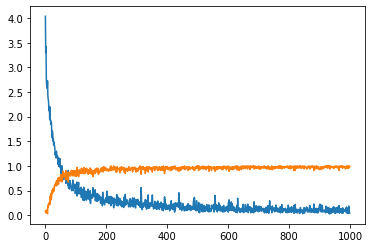

In [2]:
#imports

import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data as data 
mnist_data = data.read_data_sets('tmp/MNIST_data/', one_hot=True)


#hyperparameters

input_shape = [28, 28, 1]
num_classes = mnist_data.train.labels.shape[1]
batch_size = 64
num_kernels = [32, 64, 128]
num_iterations = 1000


#graph building

tf.reset_default_graph()

input_data = tf.placeholder(tf.float32, [batch_size] + input_shape)
expected_output = tf.placeholder(tf.float32, [batch_size, num_classes])

#megadunk egy placeholdert a batchnormalization egyik paraméterének, hogy a sessionbe tudjuk állítani
is_training = tf.placeholder_with_default(False, (), 'is_training')

current_input = input_data
input_channels = input_shape[-1]

for ind, val in enumerate(num_kernels):
  with tf.variable_scope('layer' + str(ind)):
    w = tf.get_variable('kernel', [3, 3, input_channels, val])
    b = tf.get_variable('b', [val])

    current_input = tf.nn.conv2d(input=current_input, filter=w, strides=[1,1,1,1], padding='SAME')

    #layerenként alkalmazzuk a batch normalizálást egyből a konvolúció után
    current_input = tf.layers.batch_normalization(current_input, training=is_training)

    #itt beállított rátával hagyunk el neuronokat a layerünkből
    current_input = tf.nn.dropout(current_input, rate = 0.1)

    current_input = tf.add(current_input, b)
    current_input = tf.nn.relu(current_input)
    current_input = tf.nn.max_pool(current_input, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

    input_channels = val

with tf.variable_scope('output_layer'):
  feature_length = 1
  for i in range(0, len(input_shape)):
    feature_length *= current_input.shape[-(i+1)]

  current_input = tf.reshape(current_input, [-1, feature_length])

  w = tf.get_variable('w', [feature_length, num_classes])
  b = tf.get_variable('b', [num_classes])
  current_input = tf.matmul(current_input, w)
  current_input = tf.add(current_input, b)

with tf.variable_scope('loss'):
  loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=expected_output, logits=current_input))

with tf.variable_scope('optimizer'):
  optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

with tf.name_scope('accuracy'):
  correct_predicitions = tf.equal(tf.argmax(current_input, 1), tf.argmax(expected_output, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_predicitions, tf.float32))


#session

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  loss_plot = np.zeros(num_iterations)
  acc_plot = np.zeros(num_iterations)

  for i in range(0, num_iterations):
    used_in_batch = random.sample(range(len(mnist_data.train.images)), batch_size)
    batch_x = np.reshape(mnist_data.train.images[used_in_batch], [batch_size] + input_shape)
    batch_y = mnist_data.train.labels[used_in_batch]

    #ebben a sessionben egy fix értéket adtunk az is_trainingnek így kicsit felesleges a placeholder
    #de akár ezt is szedhetnénk külső adatból
    _, l, acc = sess.run([optimizer, loss, accuracy], feed_dict={input_data: batch_x, expected_output: batch_y, is_training: True})

    loss_plot[i] = l
    acc_plot[i] = acc

    if (i%100 == 0):
      print('Iteration: ' + str(i) + ', loss: ' + str(l) + ', accuracy: ' + str(acc))

plt.plot(loss_plot)
plt.plot(acc_plot)